gc=0.020, gv=0.0000, F=0.707107, C=0.000000
gc=0.020, gv=0.0001, F=0.646989, C=0.145069
gc=0.020, gv=0.0001, F=0.647070, C=0.144997
gc=0.020, gv=0.0002, F=0.647003, C=0.144834
gc=0.020, gv=0.0002, F=0.647276, C=0.144748
gc=0.020, gv=0.0003, F=0.647053, C=0.144366
gc=0.020, gv=0.0003, F=0.647247, C=0.144090
gc=0.020, gv=0.0004, F=0.647302, C=0.143656
gc=0.020, gv=0.0004, F=0.647433, C=0.143291
gc=0.020, gv=0.0005, F=0.647531, C=0.142787
gc=0.020, gv=0.0005, F=0.647402, C=0.142171
gc=0.020, gv=0.0006, F=0.647669, C=0.141700
gc=0.020, gv=0.0006, F=0.647739, C=0.141046
gc=0.020, gv=0.0007, F=0.647852, C=0.140362
gc=0.020, gv=0.0007, F=0.648095, C=0.139618
gc=0.020, gv=0.0008, F=0.648292, C=0.138826
gc=0.020, gv=0.0008, F=0.648540, C=0.138001
gc=0.020, gv=0.0009, F=0.648699, C=0.137042
gc=0.020, gv=0.0009, F=0.649086, C=0.136275
gc=0.020, gv=0.0010, F=0.649083, C=0.135123
gc=0.020, gv=0.0010, F=0.649300, C=0.134064
gc=0.020, gv=0.0011, F=0.649600, C=0.133062
gc=0.020, gv=0.0011, F=0.649978,

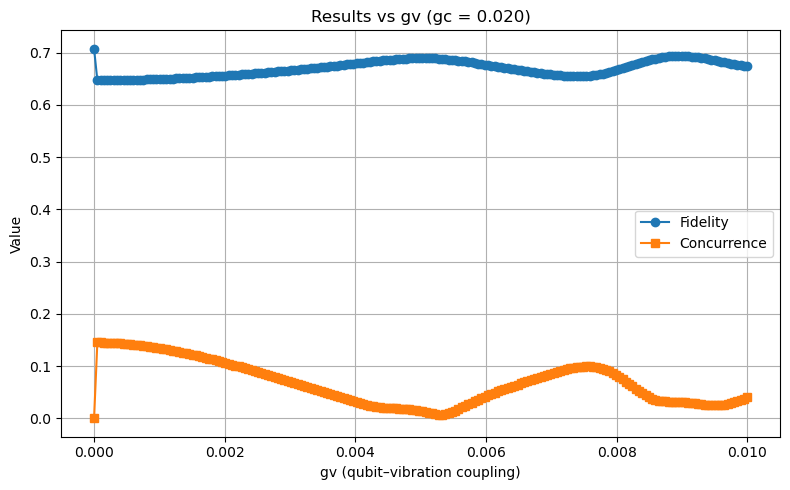

In [5]:
import numpy as np
from qutip import *
from qutip.core.gates import *
import matplotlib.pyplot as plt
import json
import csv

pi = np.pi

# -----------------------------------------------------------
# Utility functions
# -----------------------------------------------------------

def wc_t(t, args=None):
    return 1

def w1_t(t, args=None):
    if t > T0_1 and t <= T0_1 + T_gate_1:
        return 1
    else:
        return 0

def w2_t(t, args=None):
    if t > T0_2 and t <= T0_2 + T_gate_2:
        return 1
    else:
        return 0

def read_json_to_dict(filename: str) -> dict:
    with open(filename, 'r') as f:
        return json.load(f)

# -----------------------------------------------------------
# Load system parameters (LiH example)
# -----------------------------------------------------------
LiH_params = read_json_to_dict("LiH_params.json")

Nf = 4   # bosonic cutoff (increase if needed)
# local operators
sz = sigmaz()
sm = destroy(2)
sp = sm.dag()
nq = sp * sm

am = destroy(Nf)
ap = am.dag()
nc = ap * am

# identities
Iq = qeye(2)
Ic = qeye(Nf)
Iv = qeye(Nf)

# fixed frequencies: qubit and cavity on resonance
omega_q = LiH_params["w_q1"]
omega_c = omega_q  # enforce resonance
omega_v = LiH_params["w_vib1"]  # vibrational frequency (same for both)

# initial state: |e,g,0,0,0>
psi0 = tensor(basis(2,1), basis(2,0), basis(Nf,0), basis(Nf,0), basis(Nf,0))

# ideal Bell target
rho_qubits_ideal = ket2dm(
    tensor(phasegate(0), phasegate(pi/2)) *
    sqrtiswap() *
    tensor(basis(2,1), basis(2,0))
)

# -----------------------------------------------------------
# Parameter grids
# -----------------------------------------------------------

gc_fixed = 0.02   # FIXED qubit–cavity coupling
gv_values = np.linspace(0.000, 0.01, 200)   # qubit–vibration coupling

# time discretization
tlist = np.linspace(0, 1400, 5000)

# -----------------------------------------------------------
# Run sweep and collect results
# -----------------------------------------------------------
fidelities = []
concurrences = []

with open("scan_results_gv.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["gc", "gv", "Fidelity", "Concurrence"])

    H_q1 = tensor(-omega_q/2 * sz, Iq, Iv, Iv, Ic)
    H_q2 = tensor(Iq, -omega_q/2 * sz, Iv, Iv, Ic)
    H_v1 = tensor(Iq, Iq, omega_v * nc, Iv, Ic)
    H_v2 = tensor(Iq, Iq, Iv, omega_v * nc, Ic)
    H_cav = tensor(Iq, Iq, Iv, Iv, omega_v * nc)

    H_bare_total = H_q1 + H_q2 + H_v1 + H_v2 + H_cav

    for gv in gv_values:

        # interaction terms
        H_q1_cav = gc_fixed * (tensor(sp, Iq, Iv, Iv, am) + tensor(sm, Iq, Iv, Iv, ap))
        H_q2_cav = gc_fixed * (tensor(Iq, sp, Iv, Iv, am) + tensor(Iq, sm, Iv, Iv, ap))

        H_q1_vib1 = gv * tensor(sp*sm, Iq, (am+ap), Iv, Ic)
        H_q2_vib2 = gv * tensor(Iq, sp*sm, Iv, (am+ap), Ic)

        H_bare_vc = H_bare_total + H_q1_vib1 + H_q2_vib2

        # gate times fixed by gc
        global T0_1, T0_2, T_gate_1, T_gate_2
        T0_1 = 20
        T_gate_1 = pi / (4 * np.abs(gc_fixed))
        T0_2 = T0_1 + T_gate_1
        T_gate_2 = pi / (2 * np.abs(gc_fixed))

        # time-dependent Hamiltonian
        H_t = [[H_bare_vc, wc_t],
               [H_q1_cav, w1_t],
               [H_q2_cav, w2_t]]

        res = mesolve(H_t, psi0, tlist, [], e_ops=[])
        rho_final = res.states[-1]

        rho_qubits = ptrace(rho_final, [0,1])
        fide = fidelity(rho_qubits, rho_qubits_ideal)
        conc = concurrence(rho_qubits)

        fidelities.append(fide)
        concurrences.append(conc)

        writer.writerow([gc_fixed, gv, fide, conc])
        print(f"gc={gc_fixed:.3f}, gv={gv:.4f}, F={fide:.6f}, C={conc:.6f}")

# -----------------------------------------------------------
# Plot results
# -----------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(gv_values, fidelities, 'o-', label="Fidelity")
plt.plot(gv_values, concurrences, 's-', label="Concurrence")
plt.xlabel("gv (qubit–vibration coupling)")
plt.ylabel("Value")
plt.title(f"Results vs gv (gc = {gc_fixed:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
